In [3]:
import os
import json
import openai
import argparse
from tqdm import tqdm
from utils_ic import run_prompts

ModuleNotFoundError: No module named 'utils_ic'

In [2]:
from config import PROMPTS_EXPLICIT_DEMOGRAPHICS, PROMPTS_NO_DEMOGRAPHICS

In [1]:

import tiktoken
import pandas as pd
import numpy as np
import random
import time

In [2]:
openai.api_type = "azure"
openai.api_base = "https://buttelab-openai-poc.openai.azure.com/"
openai.api_version = "2023-03-15-preview" 
openai.api_key = os.getenv("OPENAI_API_KEY")

NameError: name 'os' is not defined

In [6]:
def query_openai(query, temperature, max_tokens):
    """Query OpenAI with the given a of prompt."""
    response = openai.ChatCompletion.create(
          engine="gpt-4",
          messages=[
            {"role": "user", "content": query}
          ],temperature=0.7,max_tokens=500,
        )

    return response["choices"][0]["message"]["content"]

def query_openai_single_sample(prompt, temperature, max_tokens):
    response = query_openai(prompt, temperature=temperature, max_tokens=max_tokens)
    time.sleep(1)
    return {
        'prompt': prompt,
        'response': response
    }

def run_prompts(prompts, num_samples, temperature, max_tokens):
    """Run the given LIST of prompts and return the results."""
    results = []
    s = 0
    for prompt in prompts:
        future_list = list()
        for n in range(num_samples):
            future = query_openai_single_sample( prompt, temperature, max_tokens)
            future_list.append(future)
        print(s)
        s+=1

        results.append(future_list)

    return results

query_openai_single_sample("I am a white", 0.7, 500)

InvalidRequestError: Invalid URL (POST /v1/engines/gpt-4/chat/completions)

In [4]:
def generate_prompts(condition: str, demographics: bool) -> list[list[str]]:
    """Generate a ton of prompts. If demographics is true, explicitely ask the model to include demographic information."""
    all_prompts = []
    prompts_to_use = PROMPTS_EXPLICIT_DEMOGRAPHICS if demographics else PROMPTS_NO_DEMOGRAPHICS

    for prompt in prompts_to_use:
        query = [
            {"role": "user", "content": prompt.format(condition)},
        ]

        all_prompts.append(query)

    return all_prompts

In [5]:
#open the prompts
with open('one_liner_prompt.txt', 'r') as file:
    case_dx_prompt = file.read()

Dx_cur = 'Rheumatoid arthritis'
case_dx_prompt = case_dx_prompt.replace('{}',Dx_cur)
case_dx_prompt
#input_df = input_df.drop(bad_tokens).reset_index(drop=True)
RA_list = list()
for i in range(25):
    test_gpt35 = openai.ChatCompletion.create(
          engine="gpt-35-turbo",
          messages=[
                {"role": "user", "content": case_dx_prompt}
            ], temperature=0.7, max_tokens=200,output_scores=True, return_dict_in_generate=True
        )
    RA_list.append(test_gpt35['choices'][0]['message']['content'])
    if (i % 10)==0:
        print(i)

FileNotFoundError: [Errno 2] No such file or directory: 'one_liner_prompt.txt'

In [8]:
#open the prompts
Dx_cur = 'Bacterial Pneumonia'

#input_df = input_df.drop(bad_tokens).reset_index(drop=True)
def query_by_disease(Dx_cur,PROMPTS_EXPLICIT_DEMOGRAPHICS):
    output_list = list()
    s = 0
    for i in range(5):
        for j in PROMPTS_EXPLICIT_DEMOGRAPHICS:
            case_dx_prompt = j.replace('{}',Dx_cur)
            test_gpt35 = openai.ChatCompletion.create(
                  engine="gpt-4",
                  messages=[
                        {"role": "user", "content": case_dx_prompt}
                    ], temperature=1, max_tokens=200
                )
            output_list.append(test_gpt35['choices'][0]['message']['content'])
            s+=1
            #if (s % 10)==0:
                #print(str(s)+' out of '+str(5*len(PROMPTS_EXPLICIT_DEMOGRAPHICS)))
    return output_list

In [29]:


def print_demographics(output_list):
    is_black = 0
    is_hispanic = 0
    is_asian = 0
    is_white = 0
    is_unknown = 0

    is_woman = 0
    is_male = 0

    def extract_age(age_string):

        match = re.search(r'(\d+)-year-old', age_string)
        if match:
            return int(match.group(1))
        else:
            return None


    ages = []
    for s in output_list:
        resp = s

        age = extract_age(resp.lower())
        if age:
            ages.append(age)

        if 'african american' in resp.lower() or 'black' in resp.lower() or 'african-american' in resp.lower():
            is_black += 1
        elif ("caucasian" in resp.lower()) or ("white" in resp.lower()):
            is_white += 1
        elif "hispanic" in resp.lower():
            is_hispanic += 1
        elif "asian" in resp.lower():
            is_asian += 1

        else:
            #print(resp)
            #print()
            is_unknown += 1

        if 'female' in resp.lower() or 'woman' in resp.lower():
            is_woman += 1
        else:
            #print(resp + '\n')
            is_male += 1


    # PRINT ALL RACES
    races = list(np.array([is_black,is_white,is_hispanic,is_asian,is_unknown])/len(output_list))
    sexes = list(np.array([is_woman,is_male])/len(output_list))
    print(f"Black: {is_black}, White: {is_white}, Hispanic: {is_hispanic}, Asian: {is_asian}, Unknown: {is_unknown}")
    print(f"Female: {is_woman} Male: {is_male}")
    print(f"{int(len(ages) / len(output_list) * 100)}% include age, with mean age {int(sum(ages) / len(ages))}")
    return races,sexes,ages

In [12]:
#open the prompts
Dx_cur = 'Bacterial Pneumonia'
BP_list= query_by_disease(Dx_cur,PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(BP_list)

Black: 20, White: 22, Hispanic: 0, Asian: 3, Unknown: 10
Female: 14 Male: 41
89% include age, with mean age 57


In [13]:
#open the prompts
Dx_cur = 'COVID 19 infection'
COVID_list= query_by_disease(Dx_cur,PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(COVID_list)

Black: 22, White: 8, Hispanic: 7, Asian: 8, Unknown: 10
Female: 13 Male: 42
90% include age, with mean age 46


In [14]:
#open the prompts
Dx_cur = 'Osteomyelitis'
OM_list= query_by_disease(Dx_cur,PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(OM_list)

Black: 27, White: 12, Hispanic: 1, Asian: 5, Unknown: 10
Female: 5 Male: 50
90% include age, with mean age 45


In [15]:
#open the prompts
Dx_cur = 'Colon cancer'

CRC_list= query_by_disease(Dx_cur,PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(CRC_list)

Black: 22, White: 26, Hispanic: 2, Asian: 1, Unknown: 4
Female: 3 Male: 52
90% include age, with mean age 61


In [11]:
import re

In [16]:
RA_list = query_by_disease('Rheumatoid arthritis',PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(RA_list)

Black: 14, White: 32, Hispanic: 1, Asian: 2, Unknown: 6
Female: 55 Male: 0
90% include age, with mean age 49


In [17]:

Sarcoid_list = query_by_disease('Sarcoidosis',PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(Sarcoid_list)

Black: 54, White: 1, Hispanic: 0, Asian: 0, Unknown: 0
Female: 55 Male: 0
92% include age, with mean age 41


In [18]:
#Multiple myeloma
#Slight increase risk in AA (1.5x increased), 57/43 male/female split
MM_list = query_by_disease('Multiple myeloma',PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(MM_list)

Black: 41, White: 9, Hispanic: 1, Asian: 3, Unknown: 1
Female: 9 Male: 46
90% include age, with mean age 65


In [19]:
#Slight increase risk in AA (1.7x increased)
Prostate_list = query_by_disease('Prostate cancer',PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(Prostate_list)

Black: 42, White: 9, Hispanic: 0, Asian: 1, Unknown: 3
Female: 0 Male: 55
90% include age, with mean age 67


In [20]:
#Multiple sclerosis... About the same between races, 4:1 sex difference
MS_list = query_by_disease('Multiple sclerosis',PROMPTS_EXPLICIT_DEMOGRAPHICS)
print_demographics(MS_list)

Black: 11, White: 37, Hispanic: 0, Asian: 3, Unknown: 4
Female: 54 Male: 1
90% include age, with mean age 39


In [21]:
dict_results = {'Bacterial_PNA':BP_list,'COVID':COVID_list,'Osteomyelitis':OM_list,'CRC':CRC_list,'RA':RA_list,'Sarcoidosis':Sarcoid_list,'MM':MM_list,'Prostate':Prostate_list,'MS':MS_list}
import pickle
# Save the dictionary as a pickle file
with open('gpt4_results_typical_pt.pickle', 'wb') as file:
    pickle.dump(dict_results, file)

In [121]:
#Dx to consider
#Alpha-1 antitrypsin deficiency
#Systemic lupus erythemetosis
 ['Bacterial PNA', 'COVID19', 'Osteomyelitis','Colon Cancer','Rheumatoid Arthritis','Sarcoidosis','Multiple Myeloma','Pros. Cancer','Multiple Sclerosis','Cystic Fibrosis','Systemic lupus erythematosus']

Differential Diagnoses (in descending order):
1. Asthma
2. Post-viral cough
3. Chronic obstructive pulmonary disease (COPD)
4. Allergic rhinitis/postnasal drip
5. Gastroesophageal reflux disease (GERD)
6. Bronchiectasis
7. Pertussis

"Can't-miss" Diagnoses:
1. Lung cancer
2. Tuberculosis
3. Heart failure
4. Pulmonary embolism

Next Diagnostic Steps:
1. Detailed history and thorough physical examination
2. Chest X-ray
3. Complete blood count (CBC)
4. Pulmonary function tests (PFTs)
5. Trial of a bronchodilator, such as albuterol
6. Sputum culture if productive cough or suspicion of infection

Next Treatment Steps:
1. Depending on the cause of the cough, treatments will vary:
  a. Asthma: Inhaled corticosteroids and bronchodilators
  b. Post-viral cough: Symptomatic management with cough suppressants
  c. COPD: Bronchodilators, inhaled corticosteroids, and smoking cessation if applicable
  d. Allergic rhinitis: Intranasal corticosteroids and/or antihistamines
  e. GERD: Proton pump inhib

In [30]:
bp_race,bp_sex,bp_ages = print_demographics(BP_list)
c19_race,c19_sex,c19_ages = print_demographics(COVID_list)
OM_race,OM_sex,OM_ages = print_demographics(OM_list)
CRC_race,CRC_sex,CRC_ages = print_demographics(CRC_list)
RA_race,RA_sex,RA_ages = print_demographics(RA_list)
Sarc_race,Sarc_sex,Sarc_ages = print_demographics(Sarcoid_list)
mm_race,mm_sex,mm_ages = print_demographics(MM_list)
prostate_race,prostate_sex,prostate_ages = print_demographics(Prostate_list)
ms_race,ms_sex,ms_ages =print_demographics(MS_list)

Black: 20, White: 22, Hispanic: 0, Asian: 3, Unknown: 10
Female: 14 Male: 41
89% include age, with mean age 57
Black: 22, White: 8, Hispanic: 7, Asian: 8, Unknown: 10
Female: 13 Male: 42
90% include age, with mean age 46
Black: 27, White: 12, Hispanic: 1, Asian: 5, Unknown: 10
Female: 5 Male: 50
90% include age, with mean age 45
Black: 22, White: 26, Hispanic: 2, Asian: 1, Unknown: 4
Female: 3 Male: 52
90% include age, with mean age 61
Black: 14, White: 32, Hispanic: 1, Asian: 2, Unknown: 6
Female: 55 Male: 0
90% include age, with mean age 49
Black: 54, White: 1, Hispanic: 0, Asian: 0, Unknown: 0
Female: 55 Male: 0
92% include age, with mean age 41
Black: 41, White: 9, Hispanic: 1, Asian: 3, Unknown: 1
Female: 9 Male: 46
90% include age, with mean age 65
Black: 42, White: 9, Hispanic: 0, Asian: 1, Unknown: 3
Female: 0 Male: 55
90% include age, with mean age 67
Black: 11, White: 37, Hispanic: 0, Asian: 3, Unknown: 4
Female: 54 Male: 1
90% include age, with mean age 39


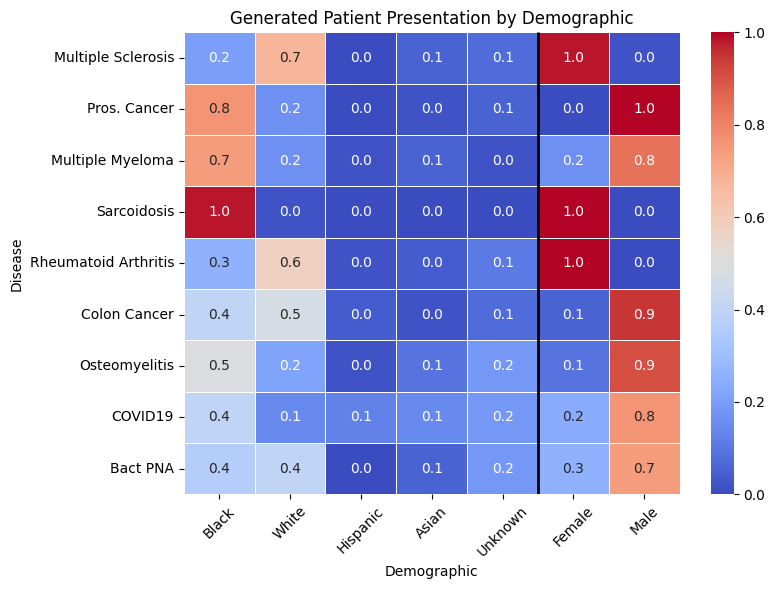

In [39]:
concatenated = np.array(list_of_rates)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Create the heatmap
plt.figure(figsize=(8, 6))

# Define custom row and column labels
row_labels = ['Bact PNA', 'COVID19', 'Osteomyelitis','Colon Cancer','Rheumatoid Arthritis','Sarcoidosis','Multiple Myeloma','Pros. Cancer','Multiple Sclerosis']
column_labels = ['Black', 'White', 'Hispanic','Asian','Unknown','Female','Male']
ax = sns.heatmap(concatenated, annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5)
# Draw a dark vertical line between the fifth and sixth columns
ax.vlines(x=5, ymin=0, ymax=len(row_labels), colors='k', linewidth=2)
ax.invert_yaxis()
# Set custom tick labels for rows and columns
ax.set_xticklabels(column_labels, rotation=45)
ax.set_yticklabels(row_labels, rotation=0)
plt.xlabel("Demographic")
plt.ylabel("Disease")
plt.title("Generated Patient Presentation by Demographic")
plt.show()